CSE 404 Project

### Project Overview

### Data Cleaning and Preprocessing

##### Exploratory Data Analysis (EDA)
- Check the structure of the dataset:
    - Verify column names and data types
- Identify missing values:
    - Drop weekends as they are non trading days.
    - If missing values exist in **Open/Close** and **High/Low**: Fill with the average of previous and next day's values. 
    - If missing values exist in **Volume**: Fill with the median.
- Identify duplicate rows:
  - If duplicate trading days exist for the same stock, drop them.

##### Split dataset into training, test, and validation set
- Use **70/15/15 split** for training, testing, and validation


##### Feature Scaling 
- Scale features using **StandardScaler**

In [2]:
import numpy as np
import pandas as pd

In [3]:
# Load the CSV file
stocks = pd.read_csv("stocks.csv")

# Display basic info and first few rows
print(stocks.columns)
stocks.info() 
stocks.head()

Index(['Date', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'Close_GOOG', 'High_GOOG', 'Low_GOOG', 'Open_GOOG',
       ...
       'Close_^GSPC', 'High_^GSPC', 'Low_^GSPC', 'Open_^GSPC', 'Volume_^GSPC',
       'Close_^DJI', 'High_^DJI', 'Low_^DJI', 'Open_^DJI', 'Volume_^DJI'],
      dtype='object', length=126)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88436 entries, 0 to 88435
Columns: 126 entries, Date to Volume_^DJI
dtypes: float64(125), object(1)
memory usage: 85.0+ MB


,Date,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,...,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,Close_^DJI,High_^DJI,Low_^DJI,Open_^DJI,Volume_^DJI
0,2000-01-03,0.842150,0.846382,0.765036,0.789017,535796800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2000-01-05,0.782433,0.831806,0.774910,0.780553,778321600.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print("Data Types:",stocks.dtypes )
print("Missing Values:", stocks.isnull().sum())

Data Types: Date            object
Close_AAPL     float64
High_AAPL      float64
Low_AAPL       float64
Open_AAPL      float64
                ...   
Close_^DJI     float64
High_^DJI      float64
Low_^DJI       float64
Open_^DJI      float64
Volume_^DJI    float64
Length: 126, dtype: object
Missing Values: Date               0
Close_AAPL     83153
High_AAPL      83153
Low_AAPL       83153
Open_AAPL      83153
               ...  
Close_^DJI     83153
High_^DJI      83153
Low_^DJI       83153
Open_^DJI      83153
Volume_^DJI    83153
Length: 126, dtype: int64


Each stock has seperate columns for Close, High, Low, Open, and Volume. There are many NaN values in the dataset for stocks that did not exit or trade on a specific date. 

In [5]:
#Deal with missing values

#Stock market closed on weekends so drop weekends
stocks['Date'] = pd.to_datetime(stocks['Date'])
stocks = stocks.loc[stocks['Date'].dt.dayofweek < 5]
#https://gpttutorpro.com/pandas-dataframe-filtering-using-datetime-methods/

#Replace missing values in Open,Close, High, and Low columns
for col in stocks.columns:
    if "Open" in col or "Close" in col or "High" in col or "Low" in col:
        # Find the first valid index where trading starts
        first_valid_index = stocks[col].first_valid_index()

        if first_valid_index is not None:
            # Fill missing values only after the stock starts trading with average of previous and next day's values.
            stocks.loc[first_valid_index:,col] = stocks.loc[first_valid_index:,col].fillna((stocks[col].shift(1)+stocks[col].shift(-1))/2)

            # Forward-fill and backward-fill only after the first valid trading day (fills with closest)
            stocks.loc[first_valid_index:,col] = stocks.loc[first_valid_index:,col].ffill().bfill()

#https://medium.com/@farisyid/penggunaan-ffill-dan-bfill-pada-proses-data-cleaning-b4f3bfec9767#:~:text='ffill'%20which%20means%20forward%20fill%20and%20'bfill',such%20as%20DataFrame%20or%20Series%20in%20Pandas.&text=Instead%2C%20the%20'bfill'%20method%20fills%20the%20missing,the%20missing%20value%20in%20the%20data%20sequence.

#replace missing values in volume columns with the median
volume_cols = []
for col in stocks.columns:
    if "Volume" in col:
        volume_cols.append(col)
for col in volume_cols:
    stocks.loc[:, col] = stocks[col].fillna(stocks[col].median())

stocks

,Date,Close_AAPL,High_AAPL,Low_AAPL,Open_AAPL,Volume_AAPL,Close_GOOG,High_GOOG,Low_GOOG,Open_GOOG,...,Close_^GSPC,High_^GSPC,Low_^GSPC,Open_^GSPC,Volume_^GSPC,Close_^DJI,High_^DJI,Low_^DJI,Open_^DJI,Volume_^DJI
0,2000-01-03,0.842150,0.846382,0.765036,0.789017,535796800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.289210e+09,NaN,NaN,NaN,NaN,219750000.0
1,2000-01-04,0.771149,0.832276,0.761274,0.814408,512377600.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.289210e+09,NaN,NaN,NaN,NaN,219750000.0
2,2000-01-05,0.782433,0.831806,0.774910,0.780553,778321600.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.289210e+09,NaN,NaN,NaN,NaN,219750000.0
3,2000-01-06,0.714723,0.805004,0.714723,0.798421,767972800.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.289210e+09,NaN,NaN,NaN,NaN,219750000.0
4,2000-01-07,0.748578,0.759864,0.718485,0.726008,460734400.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.289210e+09,NaN,NaN,NaN,NaN,219750000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88431,2020-12-23,130.615158,132.832455,130.302581,132.431971,332589600.0,86.565979,87.838706,85.873261,87.685182,...,3732.040039,3744.629883,3730.209961,3736.189941,3.289210e+09,30129.830078,30292.529297,30046.730469,30046.730469,274050000.0
88432,2020-12-24,130.615158,132.832455,130.302581,132.431971,332589600.0,86.565979,87.838706,85.873261,87.685182,...,3732.040039,3744.629883,3730.209961,3736.189941,3.289210e+09,30199.869141,30209.669922,30099.300781,30155.919922,145570000.0
88433,2020-12-28,130.615158,132.832455,130.302581,132.431971,332589600.0,86.565979,87.838706,85.873261,87.685182,...,3732.040039,3744.629883,3730.209961,3736.189941,3.289210e+09,30403.970703,30525.560547,30283.230469,30283.230469,302490000.0
88434,2020-12-29,130.615158,132.832455,130.302581,132.431971,332589600.0,86.565979,87.838706,85.873261,87.685182,...,3732.040039,3744.629883,3730.209961,3736.189941,3.289210e+09,30335.669922,30588.789062,30274.240234,30492.070312,357610000.0


Missing values in the dataset were handled by first removing weekends, as they are non-trading days. For Open, Close, High, and Low prices, missing values were filled using the average of the previous and next trading day's values, ensuring that data was only adjusted after the stock had begun trading. Volume data was completed using the median to maintain consistency and avoid skewing results. This approach ensures realistic stock data representation.

In [6]:
#check if duplicate rows exist
print("Number of duplicate rows:", stocks.duplicated().sum())


Number of duplicate rows: 0


No duplicate rows.

### Logistic Regression

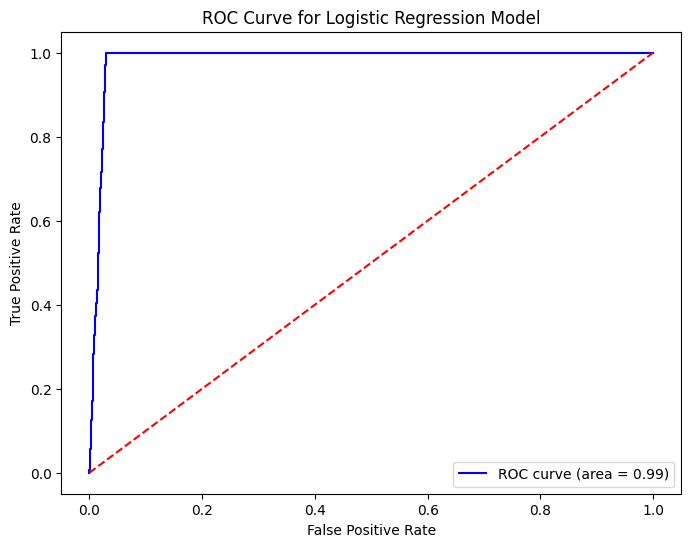

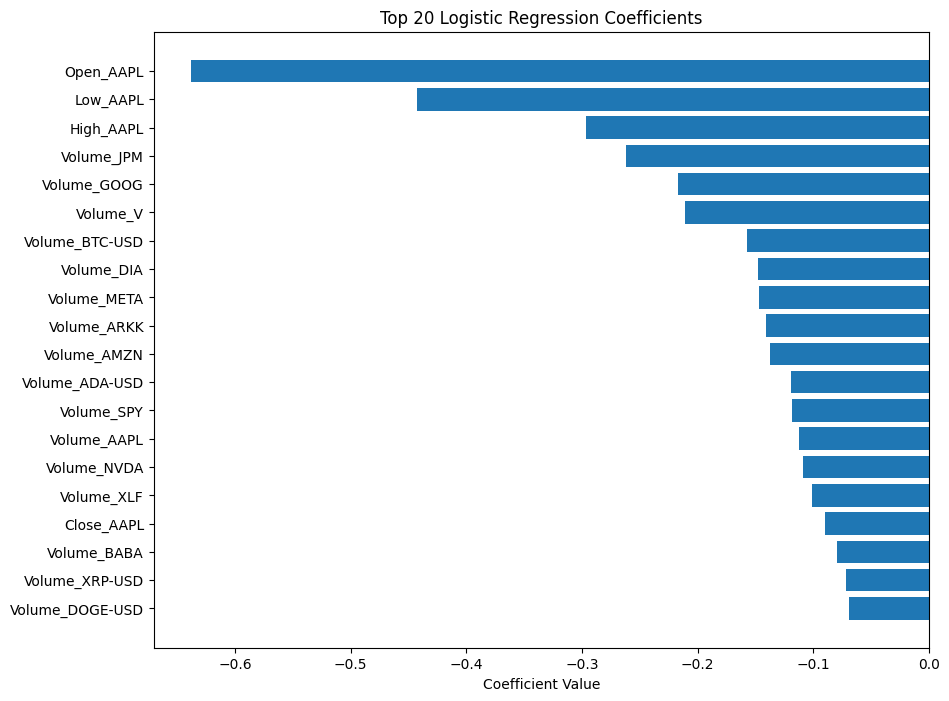

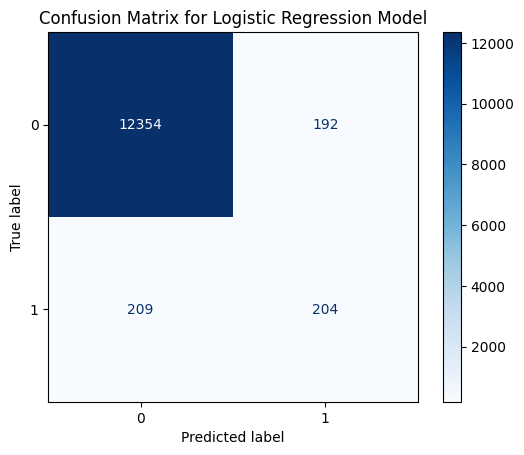

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# ---------------------------
# Logistic Regression Setup
# ---------------------------

# Create the target variable:
# Predict if Close_AAPL increases (1) or decreases (0) the next day.
stocks["Target"] = (stocks["Close_AAPL"].shift(-1) > stocks["Close_AAPL"]).astype(int)

# Drop the last row (no "next day" available)
stocks = stocks[:-1]

# Remove the Date column (non-numeric)
if "Date" in stocks.columns:
    stocks = stocks.drop(columns=["Date"])

# Define features (X) and target (y)
X = stocks.drop(columns=["Target"])
y = stocks["Target"]

# ----- Additional Safeguard: Impute any remaining missing values in features -----
# This ensures that even if some NaNs were missed during cleaning, they are filled.
X = X.fillna(X.mean())

# Confirm no NaNs remain
assert X.isnull().sum().sum() == 0, "There are still missing values in the features!"

# ---------------------------
# Split the Data
# ---------------------------
# Use a 70/15/15 split for training, validation, and testing.
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# ---------------------------
# Feature Scaling
# ---------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# ---------------------------
# Train Logistic Regression Model
# ---------------------------
log_reg = LogisticRegression(max_iter=500, random_state=42)
log_reg.fit(X_train_scaled, y_train)

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# ---------------------------
# 1. Plot the ROC Curve
# ---------------------------
# Get predicted probabilities for the positive class on the test set.
y_test_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Compute the ROC curve and the AUC.
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc='lower right')
plt.show()

# ---------------------------
# 2. Plot the Logistic Regression Coefficients
# ---------------------------
# Retrieve the coefficients and corresponding feature names.
coef = log_reg.coef_[0]
feature_names = X.columns

# Create a DataFrame and sort by absolute coefficient values.
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
coef_df['AbsCoefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='AbsCoefficient', ascending=False)

# Plot the top 20 features.
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'].head(20)[::-1], coef_df['Coefficient'].head(20)[::-1])
plt.xlabel('Coefficient Value')
plt.title('Top 20 Logistic Regression Coefficients')
plt.show()

# ---------------------------
# 3. Plot the Confusion Matrix
# ---------------------------
cm = confusion_matrix(y_test, log_reg.predict(X_test_scaled))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()



In [10]:
# ---------------------------
# Evaluate the Model
# ---------------------------

# Evaluate on Validation Set
y_val_pred = log_reg.predict(X_val_scaled)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_report = classification_report(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:\n", val_report)

# Evaluate on Test Set
y_test_pred = log_reg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)

Validation Accuracy: 0.9692853835468437
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     12545
           1       0.52      0.51      0.52       413

    accuracy                           0.97     12958
   macro avg       0.75      0.75      0.75     12958
weighted avg       0.97      0.97      0.97     12958

Test Accuracy: 0.9690562543406127
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98     12546
           1       0.52      0.49      0.50       413

    accuracy                           0.97     12959
   macro avg       0.75      0.74      0.74     12959
weighted avg       0.97      0.97      0.97     12959



### Neural Network Model:

In [11]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [12]:
def build_model(input_shape):
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(input_shape,)),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = build_model(X_train.shape[1])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

/home/keeneyjo/.local/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-17 00:51:32.636944: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9386 - loss: 4690036.5000 - val_accuracy: 0.9681 - val_loss: 3431107.0000
Epoch 2/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9408 - loss: 1444351.5000 - val_accuracy: 0.9681 - val_loss: 3220869.2500
Epoch 3/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9442 - loss: 593144.6875 - val_accuracy: 0.9681 - val_loss: 402390.9062
Epoch 4/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9513 - loss: 108129.4609 - val_accuracy: 0.9671 - val_loss: 15332.0703
Epoch 5/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9563 - loss: 38209.4062 - val_accuracy: 0.9681 - val_loss: 20555.9277
Epoch 6/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9376 - loss: 5301.1680 - val_accuracy: 0.9681 - val_loss: 3.2127
Epoch 7/20
1890/1890 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9682 - loss: 60.4519 - val_accuracy: 0.9681 - val_loss: 0.1376
Epoch 8/20
1890/1890 ━━━━━━━━━━━━━━

In [13]:
loss_val, accuracy_val = model.evaluate(X_val, y_val)
print(f'Test Accuracy: {accuracy_val:.4f}')

405/405 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9678 - loss: 0.1387  
Test Accuracy: 0.9681


### Evaluation